In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.optimizers import SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Maged\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read Data

In [2]:
train_data = pd.read_csv('train.csv')
n_turb = train_data['id'].unique().max()


## Shape the train set

In order to correctly train the Neural Network, we need to reshape the data.

The point is to obtain a train set that has shape (n_turbines, n_cycles, n_features).


In [3]:
# pick a large window size of 50 cycles
sequence_length = 100

# function to reshape features into (samples, time steps, features) 
def reshapeFeatures(id_df, seq_length, seq_cols):
    """
    Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length.
    An alternative would be to pad sequences so that
    we can use shorter ones.
    
    :param id_df: the data set to modify
    :param seq_length: the length of the window
    :param seq_cols: the columns concerned by the step
    :return: a generator of the sequences
    """
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [4]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
feat_gen = (list(reshapeFeatures(train_data[train_data['id']==id], sequence_length, sequence_cols)) 
           for id in range(1, n_turb + 1))

# generate sequences and convert to numpy array
feat_array = np.concatenate(list(feat_gen)).astype(np.float32)

print("The data set has now shape: {} entries, {} cycles and {} features.".format(feat_array.shape[0],
                                                                                  feat_array.shape[1],
                                                                                  feat_array.shape[2]))

The data set has now shape: 10631 entries, 100 cycles and 25 features.


In [5]:
# function to generate label
def reshapeLabel(id_df, seq_length=sequence_length, label=['RUL']):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length."""
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length: num_elements, :]

# generate labels
label_gen = [reshapeLabel(train_data[train_data['id']==id]) for id in range(1, n_turb + 1)]

label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(10631, 1)



## Modeling

Now that the train data set is corrected, we can build and fit the Recurrent Neural Network.
2.1 Create a Recurrent Neural Network

In order to take into account the dependancy of a given Time Serie (i.e. for a turbine), we use LSTM (Long Short Term Memory) Recurrent Neural Network.

The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units and a LSTM layer with 25 units.

Dropout is also applied after each LSTM layer to control overfitting.

Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.

The model is refined using mean_squared_error loss function.

The metrics used are root_mean_squared_error as well as mae (i.e. Mean Absolute Error). The root_mean_squared_error is easier to understand the mean_squared_error, as it is closer to the real value of the data.


In [6]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

nb_features = feat_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(GRU(input_shape=(sequence_length, nb_features), units=100, activation='relu', recurrent_activation='hard_sigmoid', recurrent_dropout=0.2,use_bias=True,
         return_sequences=True, name="GRU_0"))
model.add(Dropout(0.2, name="dropout_0"))
model.add(GRU(units=50,activation='relu', recurrent_activation='hard_sigmoid', recurrent_dropout=0.2,use_bias=True,
         return_sequences=True, name="GRU_1"))
model.add(Dropout(0.2, name="dropout_1"))
model.add(GRU(units=25, return_sequences=False, name="LSTM_2"))
model.add(Dropout(0.2, name="dropout_2"))
model.add(Dense(units=nb_out, name="dense_0"))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.add(Activation("linear", name="activation_0"))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[root_mean_squared_error, 'mae'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_0 (GRU)                  (None, 100, 100)          37800     
_________________________________________________________________
dropout_0 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
GRU_1 (GRU)                  (None, 100, 50)           22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
LSTM_2 (GRU)                 (None, 25)                5700      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 1)                 26        
__________


## Train the Recurrent Neural Network

In this step, we fit the Neural Network to the train set.

The epochs and batch_size are hyper-parameters of the Neural Network.

The callbacks parameter in the fit function allows to speed up the process and register the model.


In [7]:
epochs = 100
batch_size = 200

# fit the network
history = model.fit(feat_array, label_array, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=1)

# list all data in history
print(history.history.keys())


Train on 10099 samples, validate on 532 samples
Epoch 1/100
10099/10099 [==============================] - 43s 4ms/step - loss: 5554.7749 - root_mean_squared_error: 57.9881 - mean_absolute_error: 57.9881 - val_loss: 5221.7414 - val_root_mean_squared_error: 56.1912 - val_mean_absolute_error: 56.1912
Epoch 2/100
10099/10099 [==============================] - 40s 4ms/step - loss: 5339.9114 - root_mean_squared_error: 56.3399 - mean_absolute_error: 56.3399 - val_loss: 5076.0052 - val_root_mean_squared_error: 55.0529 - val_mean_absolute_error: 55.0529
Epoch 3/100
10099/10099 [==============================] - 40s 4ms/step - loss: 5193.8339 - root_mean_squared_error: 55.2131 - mean_absolute_error: 55.2131 - val_loss: 4934.1411 - val_root_mean_squared_error: 53.9486 - val_mean_absolute_error: 53.9486
Epoch 4/100
10099/10099 [==============================] - 40s 4ms/step - loss: 5053.1539 - root_mean_squared_error: 54.1300 - mean_absolute_error: 54.1300 - val_loss: 4795.9488 - val_root_mean_sq

10099/10099 [==============================] - 40s 4ms/step - loss: 2486.1983 - root_mean_squared_error: 37.0219 - mean_absolute_error: 37.0219 - val_loss: 2309.2117 - val_root_mean_squared_error: 36.0985 - val_mean_absolute_error: 36.0985
Epoch 34/100
10099/10099 [==============================] - 40s 4ms/step - loss: 2444.4628 - root_mean_squared_error: 36.8969 - mean_absolute_error: 36.8969 - val_loss: 2275.3401 - val_root_mean_squared_error: 36.0014 - val_mean_absolute_error: 36.0014
Epoch 35/100
10099/10099 [==============================] - 40s 4ms/step - loss: 2412.7711 - root_mean_squared_error: 36.7508 - mean_absolute_error: 36.7508 - val_loss: 2245.0325 - val_root_mean_squared_error: 35.9347 - val_mean_absolute_error: 35.9347
Epoch 36/100
10099/10099 [==============================] - 40s 4ms/step - loss: 2379.0225 - root_mean_squared_error: 36.6481 - mean_absolute_error: 36.6481 - val_loss: 2218.0822 - val_root_mean_squared_error: 35.8962 - val_mean_absolute_error: 35.8962
E

10099/10099 [==============================] - 40s 4ms/step - loss: 889.1407 - root_mean_squared_error: 17.3067 - mean_absolute_error: 17.3067 - val_loss: 731.8468 - val_root_mean_squared_error: 15.4008 - val_mean_absolute_error: 15.4008
Epoch 66/100
10099/10099 [==============================] - 40s 4ms/step - loss: 871.8513 - root_mean_squared_error: 17.2161 - mean_absolute_error: 17.2161 - val_loss: 715.1183 - val_root_mean_squared_error: 15.2754 - val_mean_absolute_error: 15.2754
Epoch 67/100
10099/10099 [==============================] - 40s 4ms/step - loss: 843.0692 - root_mean_squared_error: 16.8599 - mean_absolute_error: 16.8599 - val_loss: 657.3266 - val_root_mean_squared_error: 13.3571 - val_mean_absolute_error: 13.3571
Epoch 68/100
10099/10099 [==============================] - 40s 4ms/step - loss: 812.6551 - root_mean_squared_error: 16.5429 - mean_absolute_error: 16.5429 - val_loss: 659.3131 - val_root_mean_squared_error: 14.5996 - val_mean_absolute_error: 14.5996
Epoch 69/

Epoch 98/100
10099/10099 [==============================] - 41s 4ms/step - loss: 399.3345 - root_mean_squared_error: 12.1180 - mean_absolute_error: 12.1180 - val_loss: 281.6214 - val_root_mean_squared_error: 11.3831 - val_mean_absolute_error: 11.3831
Epoch 99/100
10099/10099 [==============================] - 40s 4ms/step - loss: 382.4392 - root_mean_squared_error: 11.8930 - mean_absolute_error: 11.8930 - val_loss: 331.0817 - val_root_mean_squared_error: 14.6841 - val_mean_absolute_error: 14.6841
Epoch 100/100
10099/10099 [==============================] - 40s 4ms/step - loss: 373.2614 - root_mean_squared_error: 11.9051 - mean_absolute_error: 11.9051 - val_loss: 262.0879 - val_root_mean_squared_error: 10.4652 - val_mean_absolute_error: 10.4652
dict_keys(['val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'loss', 'root_mean_squared_error', 'mean_absolute_error'])


## Plot the results

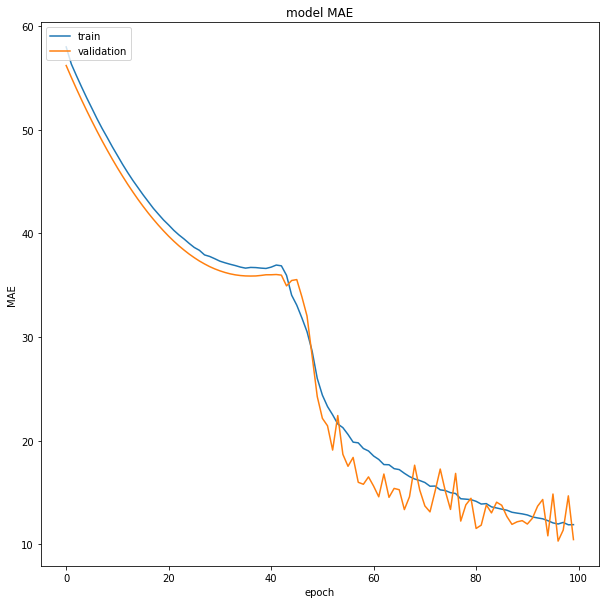

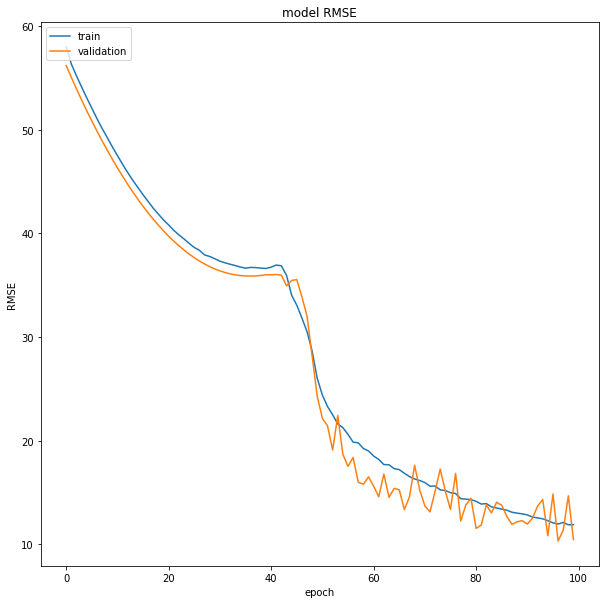

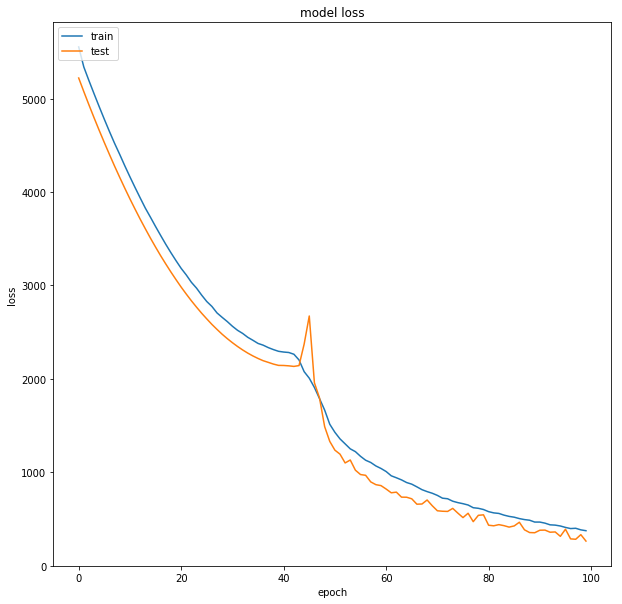

In [9]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_rmse.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")